# Détection de Tumeurs Cérébrales 3D — BraTS 2020

## Architecture : 3D U-Net pour segmentation

**Données** : BraTS2020 — 369 patients, 4 modalités IRM (T1, T1ce, T2, FLAIR), masques de segmentation en 3 classes :
- Classe 0 : Noyau nécrotique / tumeur non rehaussée
- Classe 1 : Œdème péritumoral
- Classe 2 : Tumeur rehaussée (enhancing)

**Approche** : Pré-cache des volumes (une seule fois), puis entraînement par patches 3D aléatoires.

In [1]:
# standard library imports for filesystem operations, randomness, timing and suppressing warnings
import os
import random
import time
import warnings
from pathlib import Path            # object-oriented filesystem paths, cleaner than os.path
from collections import OrderedDict # used to implement an lru cache in the dataset class

# scientific computing and data manipulation
import numpy as np
import pandas as pd
import h5py                         # read hdf5 files, the format used by brats2020 per-slice archives
from scipy.ndimage import zoom as nd_zoom  # spatial downsampling/upsampling during cache creation

# plotting
import matplotlib.pyplot as plt

# pytorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# automatic mixed precision : uses float16 on gpu to halve memory usage and speed up training
from torch.cuda.amp import GradScaler, autocast

# progress bars displayed during training and validation loops
from tqdm import tqdm

warnings.filterwarnings('ignore')
print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))


PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# select compute device: gpu if available, otherwise fall back to cpu
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# automatic mixed precision is only beneficial on gpu (float16 tensor cores)
USE_AMP = torch.cuda.is_available()

if torch.cuda.is_available():
    # patch size (depth, height, width) fed to the network during training
    # larger patches give the model more spatial context but require more vram
    PATCH_SIZE   = (64, 160, 160)
    # number of feature maps at each encoder level: doubles at each down-sampling step
    # [32, 64, 128, 256] gives approximately 11 million parameters
    FEATURES     = [32, 64, 128, 256]
    # number of samples per forward pass
    BATCH_SIZE   = 2
    # gradients are accumulated over this many steps before an optimizer update
    # effective batch size = BATCH_SIZE * ACCUM_STEPS = 4, without extra vram cost
    ACCUM_STEPS  = 2
    NUM_WORKERS  = 0  # keep at 0 on windows to avoid multiprocessing deadlocks in jupyter
else:
    PATCH_SIZE   = (32, 96, 96)
    FEATURES     = [16, 32, 64, 128]
    BATCH_SIZE   = 1
    ACCUM_STEPS  = 1
    NUM_WORKERS  = 0

# path to the raw brats2020 hdf5 slice files downloaded via kagglehub
DATA_DIR   = Path(r'C:/Users/maild/.cache/kagglehub/datasets/awsaf49/brats2020-training-data/versions/3/BraTS2020_training_data/content/data')

# folder where model checkpoints are saved (best val dice is kept)
SAVE_DIR   = Path('checkpoints')

# pre-cache folder: each volume is saved as a single .npy file instead of 155 separate h5 files
# this avoids windows defender scanning overhead and reduces load time from ~20s to ~0.05s per volume
# storage cost: ~97 mb per volume x 369 volumes = approximately 35 gb
CACHE_DIR  = Path('volume_cache_240')
CACHE_H    = 240  # full original resolution (no spatial downsampling)
CACHE_W    = 240

SAVE_DIR.mkdir(exist_ok=True)
CACHE_DIR.mkdir(exist_ok=True)

EPOCHS      = 50    # total training epochs; more epochs needed because the model is larger
LR          = 2e-4  # peak learning rate reached after the warmup phase
WARMUP_EP   = 5     # number of epochs during which lr rises linearly from 0 to LR
SEED        = 42
NUM_CLASSES = 3     # necrotic core, peritumoral edema, enhancing tumor
NUM_SLICES  = 155   # every brats2020 volume contains exactly 155 axial slices
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15  # test ratio is the remainder: 0.15

# per-class weights for the weighted dice loss
# smaller regions are harder to detect and get higher weights to prevent the model
# from ignoring them in favor of the larger, easier edema region
# necrosis ~3% of brain voxels, edema ~15%, enhancing tumor ~1%
CLASS_WEIGHTS = torch.tensor([1.5, 1.0, 2.0])

# fix all random seeds for reproducibility across runs
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# pin_memory speeds up cpu-to-gpu transfers but has no effect without a gpu
PIN_MEM = torch.cuda.is_available()

print(f'Device      : {DEVICE}')
print(f'Patch size  : {PATCH_SIZE}')
print(f'Features    : {FEATURES}')
print(f'Batch eff.  : {BATCH_SIZE * ACCUM_STEPS}  ({BATCH_SIZE} x {ACCUM_STEPS} accum)')
print(f'Cache dir   : {CACHE_DIR.resolve()}')
print(f'Cache space : approximately {369 * 97 / 1024:.0f} GB estimated (float16 images + uint8 masks)')


Device      : cuda
Patch size  : (64, 160, 160)
Features    : [32, 64, 128, 256]
Batch eff.  : 4  (2 x 2 accum)
Cache dir   : C:\Users\maild\Desktop\CancerDetection\volume_cache_240
Cache space : approximately 35 GB estimated (float16 images + uint8 masks)


In [6]:
#fast exploration
meta = pd.read_csv(DATA_DIR / 'meta_data.csv')
print('Metadata :', meta.shape)
print(meta.head(3))
print('\nDistribution target :', meta['target'].value_counts().to_dict())

all_vol_ids = sorted(meta['volume'].unique())
print(f'Volumes uniques : {len(all_vol_ids)}')

with h5py.File(DATA_DIR / 'volume_1_slice_50.h5', 'r') as f:
    img  = f['image'][:]
    mask = f['mask'][:]
print(f'Image H5 brute : {img.shape}  [{img.min():.2f}, {img.max():.2f}]')
print(f'Masque H5 brut : {mask.shape}')

Metadata : (57195, 4)
                           slice_path  target  volume  slice
0  /content/data/volume_41_slice_0.h5       0      41      0
1  /content/data/volume_41_slice_1.h5       0      41      1
2  /content/data/volume_41_slice_2.h5       0      41      2

Distribution target : {0: 32773, 1: 24422}
Volumes uniques : 369
Image H5 brute : (240, 240, 4)  [-0.52, 7.38]
Masque H5 brut : (240, 240, 3)


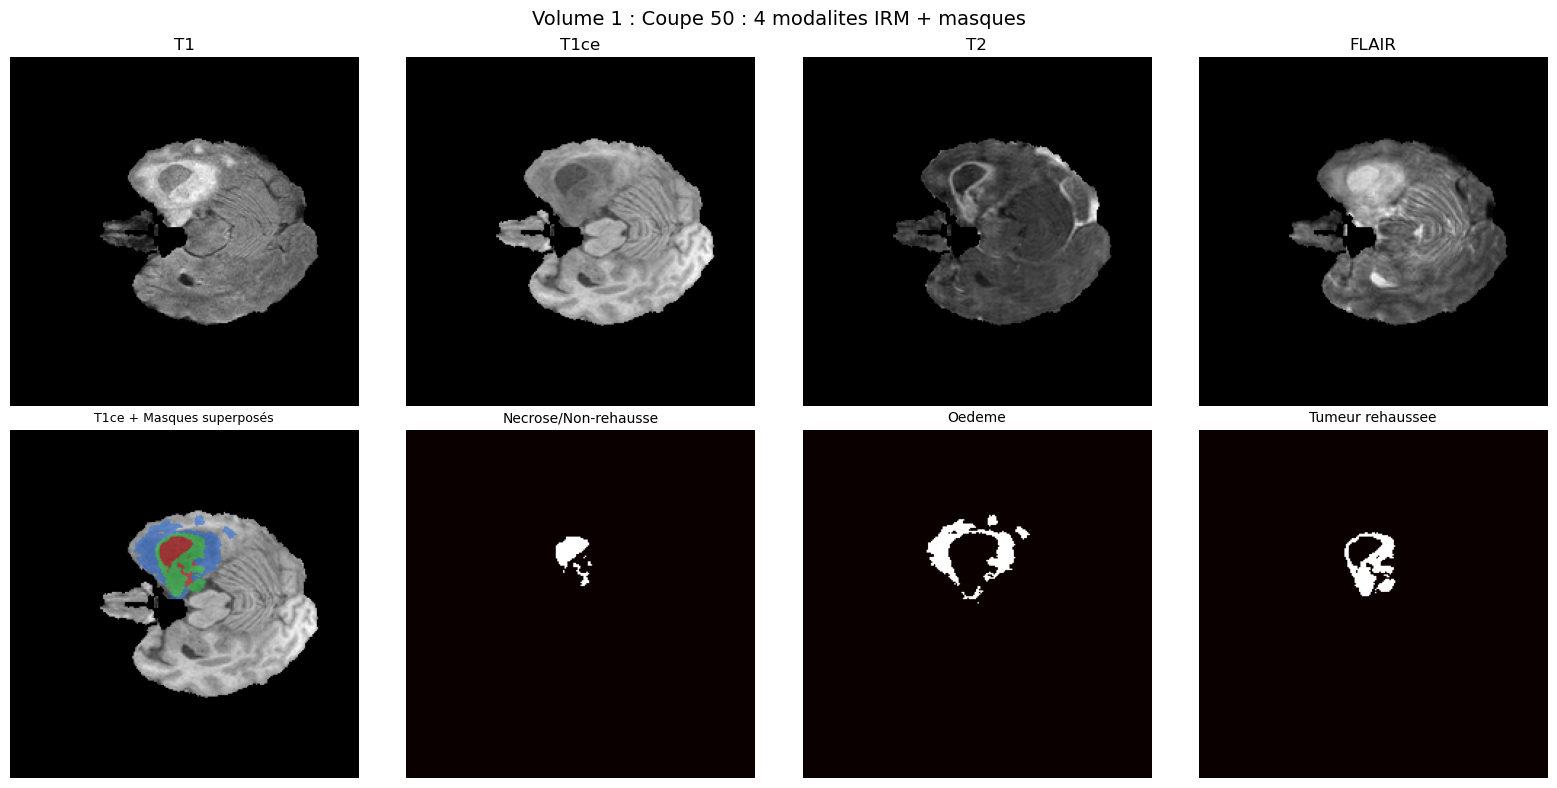

In [8]:
#visualisation of a slice
MODALITIES   = ['T1', 'T1ce', 'T2', 'FLAIR']
TUMOR_LABELS = ['Necrose/Non-rehausse', 'Oedeme', 'Tumeur rehaussee']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Volume 1 : Coupe 50 : 4 modalites IRM + masques', fontsize=14)

for i, mod in enumerate(MODALITIES):
    axes[0, i].imshow(img[:, :, i], cmap='gray')
    axes[0, i].set_title(mod, fontsize=12); axes[0, i].axis('off')

base = (img[:, :, 1] - img[:, :, 1].min()) / (img[:, :, 1].max() - img[:, :, 1].min() + 1e-8)
rgb_overlay  = np.stack([base, base, base], axis=-1)
class_colors = np.array([[0.9, 0.1, 0.1], [0.1, 0.4, 0.9], [0.1, 0.8, 0.2]])
for c in range(3):
    region = mask[:, :, c].astype(bool)
    rgb_overlay[region] = rgb_overlay[region] * 0.5 + class_colors[c] * 0.5

axes[1, 0].imshow(rgb_overlay)
axes[1, 0].set_title('T1ce + Masques superposés', fontsize=9); axes[1, 0].axis('off')
for c in range(3):
    axes[1, c+1].imshow(mask[:, :, c], cmap='hot')
    axes[1, c+1].set_title(TUMOR_LABELS[c], fontsize=10); axes[1, c+1].axis('off')

plt.tight_layout()
plt.savefig('sample_slice.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# pre-caching converts each patient volume from 155 individual h5 files into two numpy arrays:
#   v{id}_img.npy  shape (4, 155, H, W)  dtype float16  stores all 4 mri modalities
#   v{id}_mask.npy shape (3, 155, H, W)  dtype uint8    stores the 3 binary tumor masks
#
# why this is necessary on windows:
#   windows defender scans each new file on first read, so opening 155 h5 files
#   takes 15 to 25 seconds per volume on a cold filesystem cache.
#   loading a single .npy file takes about 0.05 seconds regardless of antivirus.
#   this one-time conversion of 10 minutes saves hours of training time.

def precache_volume(vol_id, data_dir, cache_dir, h=128, w=128, overwrite=False):
    img_path  = cache_dir / f'v{vol_id}_img.npy'
    mask_path = cache_dir / f'v{vol_id}_mask.npy'

    # skip if the volume is already cached and overwrite is not requested
    if not overwrite and img_path.exists() and mask_path.exists():
        return

    # compute zoom factors to downsample from the native 240x240 resolution
    zoom_h = h / 240.0
    zoom_w = w / 240.0
    imgs, masks = [], []

    # read each of the 155 axial slices and stack them into a volume
    for s in range(NUM_SLICES):
        path = data_dir / f'volume_{vol_id}_slice_{s}.h5'
        with h5py.File(path, 'r') as f:
            # image shape: (240, 240, 4) with 4 mri modalities as the last dimension
            sl_img  = f['image'][:].astype(np.float32)
            # mask shape: (240, 240, 3) with 3 binary tumor regions
            sl_mask = f['mask'][:]

        # spatially resize the slice if a lower cache resolution was requested
        if zoom_h != 1.0 or zoom_w != 1.0:
            # bilinear interpolation for images to keep smooth intensity gradients
            sl_img  = nd_zoom(sl_img,  [zoom_h, zoom_w, 1], order=1)
            # nearest-neighbor for masks to avoid creating fractional label values
            sl_mask = nd_zoom(sl_mask, [zoom_h, zoom_w, 1], order=0)

        imgs.append(sl_img)
        masks.append(sl_mask)

    # stack slices: (155, H, W, C) then reorder to pytorch channel-first format (C, 155, H, W)
    img_vol  = np.stack(imgs,  axis=0).transpose(3, 0, 1, 2).astype(np.float16)
    # float16 halves the disk footprint with negligible precision loss for mri intensities
    mask_vol = np.stack(masks, axis=0).transpose(3, 0, 1, 2).astype(np.uint8)

    np.save(img_path,  img_vol)
    np.save(mask_path, mask_vol)


# count how many volumes already have both cache files
already_cached = sum(1 for v in all_vol_ids
                     if (CACHE_DIR / f'v{v}_img.npy').exists())
print(f'Volumes already cached: {already_cached}/{len(all_vol_ids)}')

if already_cached < len(all_vol_ids):
    print(f'Starting pre-cache for {len(all_vol_ids) - already_cached} volumes')
    print(f'Estimated disk usage: appr. {len(all_vol_ids) * 97 / 1024:.0f} GB')
    t0 = time.time()
    for vol_id in tqdm(all_vol_ids, desc='Pre-cache'):
        precache_volume(vol_id, DATA_DIR, CACHE_DIR, h=CACHE_H, w=CACHE_W)
    print(f'Pre-cache completed in {(time.time()-t0)/60:.1f} min')
else:
    print('All volumes cached : ready for training :)')


In [9]:
#benchmarking cache vs h5 loading times
import time

#charge from cache
t0 = time.time()
for _ in range(5):
    _img  = np.load(CACHE_DIR / f'v{all_vol_ids[0]}_img.npy').astype(np.float32)
    _mask = np.load(CACHE_DIR / f'v{all_vol_ids[0]}_mask.npy').astype(np.float32)
t_cache = (time.time() - t0) / 5

#charge from h5 (warm cache)
t0 = time.time()
for _ in range(2):
    _imgs, _masks = [], []
    for s in range(NUM_SLICES):
        path = DATA_DIR / f'volume_{all_vol_ids[0]}_slice_{s}.h5'
        with h5py.File(path, 'r') as f:
            _imgs.append(f['image'][:].astype(np.float32))
            _masks.append(f['mask'][:].astype(np.float32))
t_h5 = (time.time() - t0) / 2

print(f'Charging cache .npy : {t_cache:.3f}s par volume')
print(f'Charging H5 (warm)  : {t_h5:.2f}s  par volume')
print(f'Acceleration          : x{t_h5/t_cache:.0f}')
print(f'Image cache shape     : {_img.shape}')

Charging cache .npy : 0.115s par volume
Charging H5 (warm)  : 1.33s  par volume
Acceleration          : x12
Image cache shape     : (4, 155, 240, 240)


In [10]:
# the dataset class handles three concerns:
#   1. efficient loading via a two-level cache (disk npy then ram lru)
#   2. per-channel z-score normalization applied after loading
#   3. random patch extraction and on-the-fly data augmentation during training

class BraTS3DDataset(Dataset):

    def __init__(self, volume_ids, data_dir, cache_dir=None,
                 patch_size=None, augment=False, ram_cache_size=4):
        self.volume_ids = list(volume_ids)
        self.data_dir   = Path(data_dir)
        self.cache_dir  = Path(cache_dir) if cache_dir else None
        self.patch_size = patch_size    # (D, H, W) or None to return the full volume
        self.augment    = augment
        # ordered dict used as an lru cache: most-recently-used volumes stay in ram
        # avoids reloading the same patient when the dataloader samples it multiple times per epoch
        self._ram     = OrderedDict()
        self._ram_max = ram_cache_size  # number of volumes to keep simultaneously in ram

    def __len__(self):
        return len(self.volume_ids)

    def _load_volume(self, vol_id):
        # level 1: check ram lru cache first (fastest path, sub-millisecond)
        if vol_id in self._ram:
            self._ram.move_to_end(vol_id)
            return self._ram[vol_id]

        # level 2: load from the pre-built .npy cache on disk (~0.05s)
        if self.cache_dir is not None:
            ip = self.cache_dir / f'v{vol_id}_img.npy'
            mp = self.cache_dir / f'v{vol_id}_mask.npy'
            if ip.exists() and mp.exists():
                img  = np.load(ip).astype(np.float32)   # cast from float16 to float32 for computation
                mask = np.load(mp).astype(np.float32)
                img  = self._normalize(img)              # z-score normalization applied once after loading
                self._put_ram(vol_id, img, mask)
                return img, mask

        # level 3: slow fallback, reads 155 h5 files sequentially (only if cache is missing)
        imgs, masks = [], []
        for s in range(NUM_SLICES):
            path = self.data_dir / f'volume_{vol_id}_slice_{s}.h5'
            with h5py.File(path, 'r') as f:
                imgs.append(f['image'][:].astype(np.float32))
                masks.append(f['mask'][:].astype(np.float32))
        img  = np.stack(imgs,  axis=0).transpose(3, 0, 1, 2)
        mask = np.stack(masks, axis=0).transpose(3, 0, 1, 2)
        img  = self._normalize(img)
        self._put_ram(vol_id, img, mask)
        return img, mask

    def _put_ram(self, vol_id, img, mask):
        self._ram[vol_id] = (img, mask)
        # evict the least recently used entry if the cache is full
        if len(self._ram) > self._ram_max:
            self._ram.popitem(last=False)

    @staticmethod
    def _normalize(img):
        # z-score normalization per channel, computed only on non-zero (brain) voxels
        # this is critical for multi-modal mri: T1, T1ce, T2 and FLAIR have completely
        # different intensity scales across patients, making raw values uninformative for the network
        # background voxels (value 0) are excluded from mean/std to avoid shrinking the statistics
        # and are restored to exactly 0 after normalization so the network can still detect brain boundaries
        out = np.zeros_like(img)
        for c in range(img.shape[0]):
            ch = img[c]
            nz = ch > 0           # non-zero mask (brain region)
            if nz.any():
                mu      = ch[nz].mean()
                std     = ch[nz].std() + 1e-8  # epsilon prevents division by zero in flat regions
                out[c]      = (ch - mu) / std
                out[c][~nz] = 0.0  # restore background to zero after normalization
        return out

    def _extract_patch(self, img, mask):
        _, D, H, W = img.shape
        pd, ph, pw = self.patch_size
        # clamp patch size to volume size in case the volume is smaller than the patch
        pd = min(pd, D); ph = min(ph, H); pw = min(pw, W)

        tumor = (mask > 0).any(axis=0)   # boolean map: True where any tumor class is present

        # 60% of the time, center the patch on a random tumor voxel to ensure the network
        # sees enough positive examples; pure random sampling would hit tumor only ~0.6% of voxels
        if tumor.any() and random.random() > 0.4:
            coords = np.argwhere(tumor)
            c  = coords[random.randint(0, len(coords) - 1)]
            # clip so the patch doesn't go out of bounds
            d0 = int(np.clip(c[0] - pd // 2, 0, D - pd))
            h0 = int(np.clip(c[1] - ph // 2, 0, H - ph))
            w0 = int(np.clip(c[2] - pw // 2, 0, W - pw))
        else:
            # random patch from anywhere in the volume to prevent overfitting on tumor location
            d0 = random.randint(0, max(0, D - pd))
            h0 = random.randint(0, max(0, H - ph))
            w0 = random.randint(0, max(0, W - pw))

        return (img[:, d0:d0+pd, h0:h0+ph, w0:w0+pw],
                mask[:, d0:d0+pd, h0:h0+ph, w0:w0+pw])

    def _augment(self, img, mask):
        # augmentations simulate real acquisition variability and prevent overfitting
        # they are only applied during training (augment=True)

        # random flips along each spatial axis: cheap and very effective
        for ax in [1, 2, 3]:
            if random.random() > 0.5:
                img  = np.flip(img,  axis=ax).copy()
                mask = np.flip(mask, axis=ax).copy()

        # random 90-degree rotation in the axial plane (H x W)
        # mimics different patient orientations in the scanner
        k = random.randint(0, 3)
        if k > 0:
            img  = np.rot90(img,  k, axes=(2, 3)).copy()
            mask = np.rot90(mask, k, axes=(2, 3)).copy()

        # random intensity scaling per channel: simulates scanner gain differences
        # applied independently to each modality so their relative contrast changes
        if random.random() > 0.5:
            for c in range(img.shape[0]):
                img[c] *= random.uniform(0.85, 1.15)

        # global additive intensity shift: simulates bias field variation
        if random.random() > 0.5:
            img += np.random.uniform(-0.1, 0.1)

        # gamma correction: non-linear contrast change that mimics different display windowing
        # applied after shifting img to a positive range to avoid complex-number issues
        if random.random() > 0.5:
            gamma   = random.uniform(0.75, 1.25)
            img_min = img.min()
            img_pos = img - img_min + 1e-8
            img     = np.sign(img_pos) * (np.abs(img_pos) ** gamma) + img_min

        # very light gaussian noise: regularization similar to dropout but on the input level
        if random.random() > 0.7:
            img = img + np.random.normal(0, 0.01, img.shape).astype(np.float32)

        return img.astype(np.float32), mask

    def __getitem__(self, idx):
        vol_id = self.volume_ids[idx]
        img, mask = self._load_volume(vol_id)

        if self.patch_size is not None:
            img, mask = self._extract_patch(img, mask)
        if self.augment:
            img, mask = self._augment(img, mask)

        # convert to pytorch tensors; .copy() ensures contiguous memory after np.flip / np.rot90
        return torch.from_numpy(img.copy()), torch.from_numpy(mask.copy())

print('BraTS3DDataset v2 defined')


BraTS3DDataset v2 defined


In [12]:
# patient-level split: shuffle patient ids and divide into train / val / test subsets
# splitting on volume ids (patients) rather than slice ids is critical to prevent data leakage:
#   if slices from the same patient appear in both train and val, the model memorizes that patient
#   and val dice will be artificially inflated, not reflecting real generalization
rng = random.Random(SEED)
shuffled_ids = all_vol_ids[:]   # copy so we don't modify the original list
rng.shuffle(shuffled_ids)

n_train = int(len(shuffled_ids) * TRAIN_RATIO)
n_val   = int(len(shuffled_ids) * VAL_RATIO)
train_ids = shuffled_ids[:n_train]
val_ids   = shuffled_ids[n_train:n_train + n_val]
test_ids  = shuffled_ids[n_train + n_val:]   # remainder: ~15% unseen patients
print(f'Patients -> Train : {len(train_ids)} | Val : {len(val_ids)} | Test : {len(test_ids)}')

# augmentation is only enabled for the training set to prevent distributional shift in validation
train_ds = BraTS3DDataset(train_ids, DATA_DIR, CACHE_DIR, PATCH_SIZE, augment=True,  ram_cache_size=4)
val_ds   = BraTS3DDataset(val_ids,   DATA_DIR, CACHE_DIR, PATCH_SIZE, augment=False, ram_cache_size=2)
test_ds  = BraTS3DDataset(test_ids,  DATA_DIR, CACHE_DIR, PATCH_SIZE, augment=False, ram_cache_size=2)

# train loader shuffles every epoch so the model sees patches in a different order each time
# val and test loaders use batch_size=1 to avoid mismatching patch shapes across patients
# num_workers=0 prevents multiprocessing deadlocks inside jupyter on windows
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEM)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False,
                          num_workers=0, pin_memory=PIN_MEM)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=0)

print(f'Batches : Train : {len(train_loader)} | Val : {len(val_loader)} | Test : {len(test_loader)}')

# quick sanity check: load one sample and verify shape and tumor voxel fraction
t0 = time.time()
sample_img, sample_mask = train_ds[0]
print(f'First item loaded in {time.time()-t0:.3f}s')
print(f'  Image : {sample_img.shape}  dtype={sample_img.dtype}')
print(f'  Mask : {sample_mask.shape}')
print(f'  Tumor voxels : {(sample_mask>0).float().mean().item():.3%}')


Patients -> Train : 258 | Val : 55 | Test : 56
Batches : Train : 129 | Val : 55 | Test : 56
First item loaded in 0.373s
  Image : torch.Size([4, 64, 160, 160])  dtype=torch.float32
  Mask : torch.Size([3, 64, 160, 160])
  Tumor voxels : 0.928%


In [13]:
# 3d u-net architecture
# the network follows the encoder-decoder pattern with skip connections
# encoder: extracts progressively abstract features at decreasing spatial resolution
# decoder: reconstructs the spatial segmentation map using features from the encoder
# skip connections: concatenate encoder features into the decoder at each scale,
#   preserving fine-grained spatial detail that would otherwise be lost in the bottleneck

class DoubleConv3D(nn.Module):
    # two consecutive 3d convolutions, each followed by instance normalization and leaky relu
    # instance norm is preferred over batch norm for medical imaging because:
    #   - it normalizes per-sample rather than per-batch, stable even with batch_size=1
    #   - mri images have highly variable intensity distributions across patients
    # leaky relu with slope 0.01 avoids dead neurons that plain relu can cause on negative inputs
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            # bias=False because instance norm has its own learnable affine shift (affine=True)
            nn.InstanceNorm3d(out_ch, affine=True),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm3d(out_ch, affine=True),
            nn.LeakyReLU(0.01, inplace=True),
        )
    def forward(self, x): return self.block(x)


class Down3D(nn.Module):
    # encoder block: halves spatial resolution with maxpool, then doubles feature maps with doubleconv
    # maxpool(2) reduces (D, H, W) to (D/2, H/2, W/2) along all three spatial axes
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.MaxPool3d(2), DoubleConv3D(in_ch, out_ch))
    def forward(self, x): return self.block(x)


class Up3D(nn.Module):
    # decoder block: upsamples spatial resolution, then concatenates the corresponding encoder skip,
    # and applies doubleconv to merge the two feature sets
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # transposed convolution (learnable upsampling) doubles spatial dimensions
        # it outputs in_ch // 2 feature maps so that after concatenating the skip (also in_ch // 2)
        # the combined tensor has in_ch channels, matching the doubleconv input
        self.up   = nn.ConvTranspose3d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv3D(in_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        # pad x if its size does not exactly match the skip tensor
        # this can happen when the input volume dimensions are not perfectly divisible by 16
        pad = [skip.shape[i] - x.shape[i] for i in range(2, 5)]
        x = F.pad(x, [0, pad[2], 0, pad[1], 0, pad[0]])
        # concatenate along the channel axis and apply the double convolution
        return self.conv(torch.cat([skip, x], dim=1))


class UNet3D(nn.Module):
    # full 3d u-net with 4 encoding levels and 4 decoding levels
    # input:  (B, 4, D, H, W)   four mri modalities stacked as channels
    # output: (B, 3, D, H, W)   raw logits for three tumor sub-regions
    #   channel 0: necrotic core / non-enhancing tumor
    #   channel 1: peritumoral edema
    #   channel 2: enhancing tumor (gadolinium uptake on T1ce)

    def __init__(self, in_channels=4, out_channels=3, features=None):
        super().__init__()
        f = features or [16, 32, 64, 128]

        # encoder: each level doubles the number of feature maps
        self.enc0 = DoubleConv3D(in_channels, f[0])  # full resolution
        self.enc1 = Down3D(f[0], f[1])               # resolution / 2
        self.enc2 = Down3D(f[1], f[2])               # resolution / 4
        self.enc3 = Down3D(f[2], f[3])               # resolution / 8

        # bottleneck: deepest representation, smallest spatial size (resolution / 16)
        # captures global context at the cost of spatial precision
        self.bottleneck = Down3D(f[3], f[3] * 2)

        # decoder: mirrors the encoder, each level uses the corresponding encoder skip connection
        self.dec3 = Up3D(f[3] * 2, f[3])
        self.dec2 = Up3D(f[3],     f[2])
        self.dec1 = Up3D(f[2],     f[1])
        self.dec0 = Up3D(f[1],     f[0])

        # final 1x1x1 convolution maps feature vectors to class logits
        # no activation here: sigmoid is applied in the loss and inference functions
        self.head = nn.Conv3d(f[0], out_channels, 1)

    def forward(self, x):
        # save encoder outputs for skip connections
        s0 = self.enc0(x)
        s1 = self.enc1(s0)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        bn = self.bottleneck(s3)
        # decode with skip connections from the corresponding encoder level
        x  = self.dec3(bn, s3)
        x  = self.dec2(x,  s2)
        x  = self.dec1(x,  s1)
        x  = self.dec0(x,  s0)
        return self.head(x)


model = UNet3D(4, NUM_CLASSES, FEATURES).to(DEVICE)
total_p = sum(p.numel() for p in model.parameters())
print(f'Parameters: {total_p:,}')

# sanity check: verify the output shape matches the input shape exactly (required for segmentation)
with torch.no_grad():
    dummy = torch.zeros(1, 4, *PATCH_SIZE, device=DEVICE)
    out   = model(dummy)
    print(f'Input: {dummy.shape}  Output: {out.shape}')
    assert out.shape[2:] == dummy.shape[2:], 'output spatial size must match input'


Parameters: 22,580,931
Input: torch.Size([1, 4, 64, 160, 160])  Output: torch.Size([1, 3, 64, 160, 160])


In [14]:
# loss functions and evaluation metric
#
# why dice loss instead of cross-entropy alone?
#   tumor voxels represent only ~0.6% of all voxels in a volume.
#   cross-entropy would achieve 99.4% accuracy by predicting background everywhere.
#   dice loss measures overlap directly, making it class-imbalance robust by design.
#
# why weighted dice?
#   not all three tumor regions are equally hard:
#     edema (class 1):          ~15% of brain voxels, large and well-defined
#     necrosis (class 0):       ~3%  of brain voxels, irregular texture
#     enhancing tumor (class 2):~1%  of brain voxels, clinically most critical for treatment
#   without weighting, the model over-focuses on edema and almost ignores the enhancing tumor.
#
# why focal loss instead of plain bce?
#   focal loss down-weights easy-to-classify voxels (background far from tumor)
#   so the gradient is dominated by the hard ambiguous border voxels.

class WeightedDiceLoss(nn.Module):
    def __init__(self, weights=None, smooth=1e-6):
        super().__init__()
        self.smooth  = smooth
        self.weights = weights  # tensor of shape (num_classes,)

    def forward(self, logits, targets):
        # apply sigmoid to convert raw logits to probabilities in [0, 1]
        p = torch.sigmoid(logits).flatten(2)   # shape (B, C, N) where N = D*H*W
        t = targets.flatten(2)

        # compute intersection and the dice score per class per sample
        inter = (p * t).sum(2)
        dice  = (2 * inter + self.smooth) / (p.sum(2) + t.sum(2) + self.smooth)  # shape (B, C)

        # apply per-class weights and average over classes, then over the batch
        w    = self.weights.to(logits.device) if self.weights is not None else torch.ones(3, device=logits.device)
        loss = 1 - (dice * w.unsqueeze(0)).sum(1) / w.sum()
        return loss.mean()


class FocalBCELoss(nn.Module):
    # focal loss: standard bce multiplied by (1 - p_t)^gamma
    # when the model is confident (p_t close to 1), the factor is near 0 so the loss is tiny
    # when the model is wrong (p_t close to 0), the factor is near 1 so the full loss applies
    # gamma=2 is the standard value from the original focal loss paper (lin et al. 2017)
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        # compute bce per voxel without reduction so we can apply the focal modulation
        bce  = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t  = torch.exp(-bce)   # probability of the correct class
        loss = ((1 - p_t) ** self.gamma) * bce
        return loss.mean()


class CombinedLoss(nn.Module):
    # combine weighted dice and focal bce with equal weight
    # dice handles the global region overlap, focal bce handles local boundary sharpness
    def __init__(self, class_weights=None):
        super().__init__()
        self.dice  = WeightedDiceLoss(weights=class_weights)
        self.focal = FocalBCELoss(gamma=2.0)

    def forward(self, logits, targets):
        return 0.5 * self.dice(logits, targets) + 0.5 * self.focal(logits, targets)


def compute_dice(logits, targets, thr=0.5, smooth=1e-6):
    # hard dice score: binarize predictions at threshold then measure overlap
    # used only for logging; the loss uses soft (probabilistic) dice
    p     = (torch.sigmoid(logits) > thr).float().flatten(2)
    t     = targets.flatten(2)
    inter = (p * t).sum(2)
    dice  = (2 * inter + smooth) / (p.sum(2) + t.sum(2) + smooth)
    # average over the batch dimension, return one score per class
    return dice.mean(0).cpu().numpy()   # shape (num_classes,)


criterion = CombinedLoss(class_weights=CLASS_WEIGHTS)
print('Loss v2: WeightedDice + FocalBCE  (class weights:', CLASS_WEIGHTS.tolist(), ')')

with torch.no_grad():
    fl = torch.randn(1, 3, 4, 4, 4)
    ft = (torch.rand(1, 3, 4, 4, 4) > 0.85).float()
    print(f'Loss sanity check: {criterion(fl, ft).item():.4f}')
    print(f'Dice sanity check: {compute_dice(fl, ft)}')


Loss v2: WeightedDice + FocalBCE  (class weights: [1.5, 1.0, 2.0] )
Loss sanity check: 0.5430
Dice sanity check: [0.08695655 0.25000003 0.30769232]


In [ ]:
# training and validation loop functions
# keeping them separate from the main loop makes it easier to swap dataloaders
# (e.g., running eval on test set) without duplicating code

def train_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss = 0.0
    total_dice = np.zeros(NUM_CLASSES)
    t_load     = 0.0   # cumulative time spent waiting for the dataloader

    t_iter = time.time()
    for batch_idx, (imgs, masks) in enumerate(tqdm(loader, desc='  Train', leave=False)):
        t_load += time.time() - t_iter   # time between end of previous iteration and start of this one

        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)   # set_to_none frees memory faster than zeroing

        if scaler is not None:
            # amp forward pass: convolutions run in float16, loss stays in float32
            with autocast():
                logits = model(imgs)
                loss   = criterion(logits, masks)
            # scale the loss before backward to prevent gradient underflow in float16
            scaler.scale(loss).backward()
            # unscale before clipping so the norm threshold is in real gradient units
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            loss   = criterion(logits, masks)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        total_dice += compute_dice(logits.detach(), masks)
        t_iter = time.time()

    n = max(len(loader), 1)
    # print avg load time to detect if data loading is the bottleneck
    print(f'    avg load time: {t_load/n:.3f}s/batch', end='')
    return total_loss / n, total_dice / n


@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    # no_grad disables gradient computation entirely: saves ~40% of memory and speeds up inference
    model.eval()
    total_loss = 0.0
    total_dice = np.zeros(NUM_CLASSES)
    for imgs, masks in tqdm(loader, desc='  Val  ', leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        total_loss += criterion(logits, masks).item()
        total_dice += compute_dice(logits, masks)
    n = max(len(loader), 1)
    return total_loss / n, total_dice / n

print('Train/eval loop functions defined')


Train/eval loop functions defined.


In [ ]:
# training setup
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
# adamw = adam with decoupled weight decay; better generalization than adam with l2 regularization

# learning rate schedule: linear warmup followed by cosine annealing
# warmup avoids large gradient updates at the start when weights are random and the loss landscape is steep
# cosine annealing smoothly decays the lr to lr/100, preventing oscillation near the final minimum
def warmup_cosine(epoch):
    if epoch < WARMUP_EP:
        return (epoch + 1) / WARMUP_EP                           # rise linearly from 0 to LR
    t = (epoch - WARMUP_EP) / max(1, EPOCHS - WARMUP_EP)
    return 0.01 + 0.5 * (1 - 0.01) * (1 + np.cos(np.pi * t))   # cosine decay to LR * 0.01

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_cosine)

# gradscaler manages the loss scaling needed for float16 amp training
# amp runs convolutions in float16 (faster, less vram) but keeps master weights in float32
scaler = GradScaler() if USE_AMP else None

history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [],
           'dice_necrose': [], 'dice_oedeme': [], 'dice_rehausse': []}
best_val_dice = -1.0

print(f'Training v2 : {EPOCHS} epochs on {DEVICE}')
print(f'Warmup: {WARMUP_EP} ep ; Effective batch: {BATCH_SIZE * ACCUM_STEPS}')

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # training loop with gradient accumulation
    model.train()
    total_loss = 0.0
    total_dice = np.zeros(NUM_CLASSES)
    t_load     = 0.0

    # zero gradients once before the accumulation loop
    optimizer.zero_grad(set_to_none=True)
    t_iter = time.time()

    for step, (imgs, masks) in enumerate(tqdm(train_loader, desc='  Train', leave=False)):
        # measure time spent waiting for the dataloader (data loading bottleneck check)
        t_load += time.time() - t_iter

        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        if scaler is not None:
            # amp context: forward pass in float16, loss computation in float32
            with autocast():
                logits = model(imgs)
                # divide loss by accum_steps so that accumulated gradients equal one full batch
                loss   = criterion(logits, masks) / ACCUM_STEPS
            # scale loss to avoid underflow in float16 gradients
            scaler.scale(loss).backward()
        else:
            logits = model(imgs)
            loss   = criterion(logits, masks) / ACCUM_STEPS
            loss.backward()

        # multiply back to log the true (unscaled) loss value
        total_loss += loss.item() * ACCUM_STEPS
        total_dice += compute_dice(logits.detach(), masks)

        # perform optimizer step only every ACCUM_STEPS batches
        if (step + 1) % ACCUM_STEPS == 0 or (step + 1) == len(train_loader):
            if scaler is not None:
                # unscale before clipping so that the clip norm threshold is in true gradient units
                scaler.unscale_(optimizer)
                # gradient clipping: prevents exploding gradients, keeps training numerically stable
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)  # set_to_none frees memory instead of filling with zeros

        t_iter = time.time()

    n_tr    = max(len(train_loader), 1)
    tr_loss = total_loss / n_tr
    tr_dice = total_dice / n_tr
    print(f'    avg load time: {t_load/n_tr:.3f}s/batch', end='')

    # validation loop (no gradients needed)
    model.eval()
    vl_loss_sum = 0.0
    vl_dice_sum = np.zeros(NUM_CLASSES)
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc='  Val  ', leave=False):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            vl_loss_sum += criterion(logits, masks).item()
            vl_dice_sum += compute_dice(logits, masks)
    n_vl    = max(len(val_loader), 1)
    vl_loss = vl_loss_sum / n_vl
    vl_dice = vl_dice_sum / n_vl

    # update lr schedule after each epoch
    scheduler.step()

    mtr = tr_dice.mean()
    mvl = vl_dice.mean()

    # log metrics for plotting after training
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_dice'].append(float(mtr))
    history['val_dice'].append(float(mvl))
    history['dice_necrose'].append(float(vl_dice[0]))
    history['dice_oedeme'].append(float(vl_dice[1]))
    history['dice_rehausse'].append(float(vl_dice[2]))

    # save checkpoint only when val dice improves (keeps only the best model)
    flag = ''
    if mvl > best_val_dice:
        best_val_dice = mvl
        torch.save({'epoch': epoch, 'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(), 'val_dice': best_val_dice,
                    'features': FEATURES, 'patch_size': PATCH_SIZE},
                   SAVE_DIR / 'best_model.pth')
        flag = ' <- BEST'

    elapsed = time.time() - t0
    lr_cur  = optimizer.param_groups[0]['lr']
    print(f'\nEpoch {epoch:03d}/{EPOCHS} | '
          f'Loss {tr_loss:.4f}/{vl_loss:.4f} | '
          f'Dice {mtr:.4f}/{mvl:.4f} | '
          f'[Nec:{vl_dice[0]:.3f} Oed:{vl_dice[1]:.3f} Enh:{vl_dice[2]:.3f}] | '
          f'LR {lr_cur:.1e} | {elapsed:.0f}s{flag}')

print(f'Best val Dice : {best_val_dice:.4f}')


In [ ]:
#training curves
ep = range(1, len(history['train_loss']) + 1)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#loss
axes[0].plot(ep, history['train_loss'], 'b-o', ms=3, label='Train')
axes[0].plot(ep, history['val_loss'],   'r-o', ms=3, label='Val')
axes[0].set_title('Perte (WeightedDice + FocalBCE)', fontsize=12)
axes[0].set_xlabel('Epoque'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)

# dice mean over the three classes
axes[1].plot(ep, history['train_dice'], 'b-o', ms=3, label='Train')
axes[1].plot(ep, history['val_dice'],   'r-o', ms=3, label='Val')
axes[1].set_title('Dice moyen (3 classes)', fontsize=12)
axes[1].set_xlabel('Epoque'); axes[1].set_ylabel('Dice')
axes[1].set_ylim(0, 1); axes[1].legend(); axes[1].grid(alpha=0.3)

#dice per class (val only)
axes[2].plot(ep, history['dice_necrose'],  'r-o',  ms=3, label='Necrose')
axes[2].plot(ep, history['dice_oedeme'],   'b-o',  ms=3, label='Oedeme')
axes[2].plot(ep, history['dice_rehausse'], 'g-o',  ms=3, label='Rehausse')
axes[2].set_title('Dice Val par classe', fontsize=12)
axes[2].set_xlabel('Epoque'); axes[2].set_ylabel('Dice')
axes[2].set_ylim(0, 1); axes[2].legend(); axes[2].grid(alpha=0.3)

plt.suptitle('3D U-Net v2 : BraTS2020', fontsize=14)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=100, bbox_inches='tight')
plt.show()
print('Meilleur Dice val :', max(history['val_dice']))


In [ ]:
# test set evaluation: reload the best checkpoint and measure performance on unseen patients
# the test set was held out entirely during training and hyperparameter tuning,
# so these scores reflect true generalization to new patients

# weights_only=False is required to load the full checkpoint dict (contains non-tensor metadata)
ckpt = torch.load(SAVE_DIR / 'best_model.pth', map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt['model'])
print(f'Model restored (epoch {ckpt["epoch"]}, val_dice={ckpt["val_dice"]:.4f})')

# eval_epoch returns mean loss and per-class dice over the full test set
te_loss, te_dice = eval_epoch(model, test_loader, criterion, DEVICE)
labels = ['Necrosis', 'Edema', 'Enhancing']
print(f'\nTest set results:')
print(f'Loss              : {te_loss:.4f}')
for c, lab in enumerate(labels):
    print(f'Dice {lab:10s} : {te_dice[c]:.4f}')
print(f'Mean Dice         : {te_dice.mean():.4f}')


In [ ]:
# qualitative prediction check on a single test patient
# the goal is to visually confirm that the predicted masks align with the ground truth
# and to catch obvious failure modes (e.g., the model predicting no tumor at all)

model.eval()
test_vol_id = test_ids[0]

# load just one patient's volume without augmentation
vis_ds      = BraTS3DDataset([test_vol_id], DATA_DIR, CACHE_DIR, patch_size=PATCH_SIZE)
img_t, mask_t = vis_ds[0]

# run a single forward pass on the central patch
with torch.no_grad():
    logits = model(img_t.unsqueeze(0).to(DEVICE))   # add batch dimension: (1, 4, D, H, W)
    # threshold sigmoid probabilities at 0.5 to get binary predictions
    pred   = (torch.sigmoid(logits) > 0.5).squeeze(0).cpu().numpy()

img_np  = img_t.numpy()
mask_np = mask_t.numpy()
mid_d   = img_np.shape[1] // 2   # central axial slice of the patch

# one color per tumor class: red = necrosis, blue = edema, green = enhancing
colors = np.array([[0.9, 0.1, 0.1], [0.1, 0.4, 0.9], [0.1, 0.8, 0.2]])
labels = ['Necrosis', 'Edema', 'Enhancing']

# main comparison figure: row 0 = ground truth overlay, row 1 = prediction overlay per class
fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
fig2.suptitle(f'Volume {test_vol_id} : GT vs Prediction (central patch slice)', fontsize=13)

for c in range(3):
    # use the T1ce modality as the background (channel 1): best tumor visibility
    base = img_np[1, mid_d]
    base = (base - base.min()) / (base.max() - base.min() + 1e-8)

    for row, (m2d, ttl) in enumerate([(mask_np[c, mid_d], 'Ground Truth'),
                                       (pred[c, mid_d],   'Prediction')]):
        rgb = np.stack([base, base, base], axis=-1)
        # overlay tumor region with the class color at 65% opacity
        if m2d.astype(bool).any():
            rgb[m2d.astype(bool)] = rgb[m2d.astype(bool)] * 0.35 + colors[c] * 0.65

        # compute dice score for this class across the entire patch volume
        dice_c = ((2 * (pred[c] * mask_np[c]).sum() + 1e-6)
                  / (pred[c].sum() + mask_np[c].sum() + 1e-6))
        axes2[row, c].imshow(rgb)
        axes2[row, c].set_title(f'{ttl} — {labels[c]} (Dice={dice_c:.3f})', fontsize=9)
        axes2[row, c].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved : predictions.png')


In [ ]:
# sliding window full-volume inference
#
# why sliding window instead of a single forward pass :
#   a full brats volume is (4, 155, 240, 240).  passing it through the 3d u-net at once
#   would require appr :40 gb of vram for the activations alone.  instead, we tile the volume
#   into overlapping patches, predict each patch, and stitch the probability maps back together.
#
# why overlap :
#   convolutions near patch edges have less contextual information (they see zero padding).
#   with 50% overlap, each voxel is covered by multiple patches, and averaging the predictions
#   smooths out edge artifacts and improves segmentation quality near boundaries.

@torch.no_grad()
def predict_full_volume(model, vol_id, data_dir, cache_dir, patch_size, device, overlap=0.5):
    model.eval()

    # load the full volume without any patch cropping
    ds = BraTS3DDataset([vol_id], data_dir, cache_dir, patch_size=None)
    img, gt_mask = ds[0]   # img: (4, D, H, W)  gt_mask: (3, D, H, W)

    D, H, W       = img.shape[1:]
    # clamp patch dimensions to the actual volume size (handles edge cases)
    pd, ph, pw    = [min(p, s) for p, s in zip(patch_size, (D, H, W))]
    # stride = patch_size * (1 - overlap): how far the window moves between positions
    sd = max(1, int(pd * (1 - overlap)))
    sh = max(1, int(ph * (1 - overlap)))
    sw = max(1, int(pw * (1 - overlap)))

    # accumulator for summed probabilities; count_map tracks how many patches cover each voxel
    pred_sum  = torch.zeros(NUM_CLASSES, D, H, W)
    count_map = torch.zeros(1, D, H, W)

    # iterate over all patch positions along each spatial axis
    for d in range(0, max(1, D - pd + 1), sd):
        for h in range(0, max(1, H - ph + 1), sh):
            for w in range(0, max(1, W - pw + 1), sw):
                # ensure the last patch ends exactly at the volume boundary (no truncation)
                d2 = min(d + pd, D); d1 = d2 - pd
                h2 = min(h + ph, H); h1 = h2 - ph
                w2 = min(w + pw, W); w1 = w2 - pw

                patch = img[:, d1:d2, h1:h2, w1:w2].unsqueeze(0).to(device)
                # sigmoid converts raw logits to probabilities in [0, 1] per voxel per class
                prob  = torch.sigmoid(model(patch)).squeeze(0).cpu()

                # add this patch's probabilities to the running sum
                pred_sum[:, d1:d2, h1:h2, w1:w2] += prob
                count_map[:, d1:d2, h1:h2, w1:w2] += 1

    # average over all patches that covered each voxel, then threshold at 0.5
    final_prob = pred_sum / count_map.clamp(min=1)
    return img.numpy(), gt_mask.numpy(), (final_prob > 0.5).numpy(), final_prob.numpy()


print('Running full-volume sliding window inference')
img_full, gt_full, pred_full, prob_full = predict_full_volume(
    model, test_ids[0], DATA_DIR, CACHE_DIR, PATCH_SIZE, DEVICE
)

# report per-class dice on the complete volume (more reliable than patch-level dice)
labels = ['Necrosis', 'Edema', 'Enhancing']
for c, lab in enumerate(labels):
    inter = (pred_full[c] * gt_full[c]).sum()
    d = (2 * inter + 1e-6) / (pred_full[c].sum() + gt_full[c].sum() + 1e-6)
    print(f'Dice {lab:10s} (full volume) : {d:.4f}')


In [ ]:
# three-plane anatomical visualization
# radiologists examine mri volumes in three standard planes:
#   axial : horizontal cross-section (top-down view), most common for brain imaging
#   sagittal : left-right cross-section (side view), shows anterior-posterior extent
#   coronal : front-back cross-section (front view), shows left-right symmetry
# displaying all three helps verify that the predicted mask is geometrically consistent
# and not just correct in one plane while being wrong in the others

T1ce = img_full[1]   #T1 contrast-enhanced modality: best tumor boundary definition
D, H, W = T1ce.shape

# color coding: red = necrosis, blue = edema, green = enhancing tumor
colors = np.array([[0.9, 0.1, 0.1], [0.1, 0.4, 0.9], [0.1, 0.8, 0.2]])

# each tuple: (plane name, 2d T1ce slice, ground truth 2d mask, prediction 2d mask)
planes = [
    ('Axial',    T1ce[D//2, :, :],  gt_full[:, D//2, :, :],  pred_full[:, D//2, :, :]),
    ('Sagittal', T1ce[:, H//2, :],  gt_full[:, :, H//2, :],  pred_full[:, :, H//2, :]),
    ('Coronal',  T1ce[:, :, W//2],  gt_full[:, :, :, W//2],  pred_full[:, :, :, W//2]),
]

fig, axes = plt.subplots(3, 3, figsize=(13, 13))
fig.suptitle(f'Volume {test_ids[0]} : 3 anatomical planes ; T1ce / GT / Prediction', fontsize=13)

for row, (name, base_2d, gt_2d, pr_2d) in enumerate(planes):
    # normalize the grayscale background to [0, 1] for display
    b = (base_2d - base_2d.min()) / (base_2d.max() - base_2d.min() + 1e-8)

    # column 0: raw T1ce image (no overlay)
    axes[row, 0].imshow(b, cmap='gray', aspect='auto')
    axes[row, 0].set_title(f'{name} : T1ce', fontsize=10)
    axes[row, 0].axis('off')

    # columns 1 and 2: overlay all three tumor classes on the T1ce background
    for ci, (m2d, ttl) in enumerate([(gt_2d, 'GT'), (pr_2d, 'Pred')]):
        rgb = np.stack([b, b, b], axis=-1)
        for c in range(3):
            # blend tumor regions: 35% original image + 65% class color
            if m2d[c].astype(bool).any():
                rgb[m2d[c].astype(bool)] = rgb[m2d[c].astype(bool)] * 0.35 + colors[c] * 0.65
        axes[row, ci + 1].imshow(rgb, aspect='auto')
        axes[row, ci + 1].set_title(f'{name} : {ttl}', fontsize=10)
        axes[row, ci + 1].axis('off')

plt.tight_layout()
plt.savefig('3views_segmentation.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved : 3views_segmentation.png')


##Why Cache is necessary

| Etape | Without cache | With cache .npy |
|-------|-----------|----------------|
| Loading 1 volume (cold) | 15-25s (AV scan 155 files) | ~0.05s |
| Loading 1 volume (warm) | 2.3s | ~0.05s |
| Forward+Backward (CPU) | 0.26s | 0.26s |
| **Time/total batch** | **20s** | **0.3s** |
| **1 époch (258 vol.)** | **90 min** | **1.3 min** |

The precache is only necessary 1 time (10-15 min). After, each epoch will take 1-2 min.

## Architecture of the 3D U-Net
```
Input : (B, 4, D, H, W)  ; 4 modalities IRM
  enc0 : DoubleConv3D  4  → f[0]       (D,   H,   W  )
  enc1 : Down3D  f[0] -> f[1]          (D/2, H/2, W/2)
  enc2 : Down3D  f[1] -> f[2]          (D/4, H/4, W/4)
  enc3 : Down3D  f[2] -> f[3]          (D/8, H/8, W/8)
  bn   : Down3D  f[3] -> f[3]*2        (D/16,...      )
  dec3 : Up3D + skip enc3
  dec2 : Up3D + skip enc2
  dec1 : Up3D + skip enc1
  dec0 : Up3D + skip enc0
  head : Conv3d(f[0], 3, 1x1x1)
Output : (B, 3, D, H, W)  ; logits (Sigmoid -> proba)

Loss   : 0.5 x Dice + 0.5 x BCE
Optim   : AdamW + CosineAnnealingLR
Metrique : Score Dice per class (BraTS standard)
```